In [1]:
from tedana.cli import run
import pandas as pd
from numba import jit
from scipy.linalg import expm
from time import gmtime, strftime

from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
%load_ext line_profiler

In [2]:
import os
import sys
import gzip
import pickle
import numpy as np
import nibabel as nib
from sklearn import svm
import scipy.stats as stats
from tedana.interfaces.t2smap import (optcom, t2sadmap)
from tedana.utils.utils import (cat2echos, uncat2echos, make_mask,
                                makeadmask, fmask, unmask,
                                fitgaussian, niwrite, dice, andb)


"""
PROCEDURE 2 : Computes ME-PCA and ME-ICA
-Computes T2* map
-Computes PCA of concatenated ME data, then computes TE-dependence of PCs
-Computes ICA of TE-dependence PCs
-Identifies TE-dependent ICs, outputs high-\kappa (BOLD) component
   and denoised time series
-or- Computes TE-dependence of each component of a general linear model
   specified by input (includes MELODIC FastICA mixing matrix)
PROCEDURE 2a: Model fitting and component selection routines
"""

F_MAX = 500
Z_MAX = 8


def do_svm(X_train, y_train, X_test, svmtype=0):
    """
    sklearn's Support Vector Classification (SVC).
    For svmtype=1, implemented in liblinear rather than libsvm.

    Parameters
    ----------
    X_train : {array-like, sparse matrix}, shape (n_samples, n_features)
        Training vectors, where n_samples is the number of samples in the
        training dataset and n_features is the number of features.
    y_train : array-like, shape (n_samples,)
        Target values (class labels in classification, real numbers in
        regression)
    X_test : {array-like, sparse matrix}, shape (n_samples, n_features)
        Test vectors, where n_samples is the number of samples in the test
        dataset and n_features is the number of features.
    svmtype : int
        Desired support vector machine type.

    Returns
    -------
    y_pred : array, shape (n_samples,)
        Predicted class labels for samples in X_test.
    clf : {:obj:`sklearn.svm.classes.SVC`, :obj:`sklearn.svm.classes.LinearSVC`}
        Trained sklearn model instance.
    """

    if svmtype == 0:
        clf = svm.SVC(kernel='linear')
    elif svmtype == 1:
        clf = svm.LinearSVC(loss='squared_hinge', penalty='l1', dual=False)
    elif svmtype == 2:
        clf = svm.SVC(kernel='linear', probability=True)
    else:
        raise ValueError('Input svmtype not in range (3)')

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    return y_pred, clf


def spatclust(data, mask, csize, thr, header, aff, infile=None, dindex=0,
              tindex=0):
    """

    Parameters
    ----------
    data :

    mask :

    csize :

    thr :

    header :

    aff :

    infile :

    dindex :

    tindex :


    Returns
    -------
    clustered :


    """
    if infile is None:
        data = data.copy()
        data[data < thr] = 0
        niwrite(unmask(data, mask), aff, '__clin.nii.gz', header)
        infile = '__clin.nii.gz'
    addopts = ''
    if data is not None and len(np.squeeze(data).shape) > 1 and dindex + tindex == 0:
        addopts = '-doall'
    else:
        addopts = '-1dindex {0} -1tindex {1}'.format(str(dindex), str(tindex))

    cmd_str = '3dmerge -overwrite {0} -dxyz=1  -1clust 1 {1:d} -1thresh {2:.02f} -prefix __clout.nii.gz {3}'
    os.system(cmd_str.format(addopts, int(csize), float(thr), infile))
    clustered = fmask(nib.load('__clout.nii.gz').get_data(), mask) != 0
    return clustered


def rankvec(vals):
    """Returns ranks of array.

    Parameters
    ----------
    vals : array-like
        1d array from which to determine ranks.

    Returns
    -------
    ranks : array-like
        1d array of ranks for values in input vals.
    """
    try:
        vals = np.array(vals)
    except:
        raise IOError('Input vals is not array_like')

    if len(vals.shape) != 1:
        raise ValueError('Input vals is not 1d array')

    asort = np.argsort(vals)
    ranks = np.zeros(vals.shape[0])
    ranks[asort] = np.arange(vals.shape[0]) + 1
    return ranks


def get_coeffs(data, mask, X, add_const=False):
    """
    get_coeffs(data,X)

    Parameters
    ----------
    data : array-like
        Array of shape (nx, ny, nz, nt)
    mask : array-like
        Array of shape (nx, ny, nz)
    X : array-like
        Array of shape (nt, nc)
    add_const : bool, optional
        Default is False.

    Returns
    -------
    out : array_like
        Array of shape (nx, ny, nz, nc)
    """
    mdata = fmask(data, mask).transpose()

    # Coerce X to >=2d
    X = np.atleast_2d(X)

    if X.shape[0] == 1:
        X = X.T
    Xones = np.atleast_2d(np.ones(np.min(mdata.shape))).T
    if add_const:
        X = np.hstack([X, Xones])

    tmpbetas = np.linalg.lstsq(X, mdata)[0].transpose()
    if add_const:
        tmpbetas = tmpbetas[:, :-1]
    out = unmask(tmpbetas, mask)

    return out


def getelbow_cons(ks, val=False):
    """Elbow using mean/variance method - conservative

    Parameters
    ----------
    ks : array-like

    val : bool, optional
        Default is False

    Returns
    -------
    array-like
        Either the elbow index (if val is True) or the values at the elbow
        index (if val is False)
    """
    ks = np.sort(ks)[::-1]
    nk = len(ks)
    temp1 = [(ks[nk-5-ii-1] > ks[nk-5-ii:nk].mean() + 2*ks[nk-5-ii:nk].std()) for ii in range(nk-5)]
    ds = np.array(temp1[::-1], dtype=np.int)
    dsum = []
    c_ = 0
    for d_ in ds:
        c_ = (c_ + d_) * d_
        dsum.append(c_)
    e2 = np.argmax(np.array(dsum))
    elind = np.max([getelbow_mod(ks), e2])

    if val: return ks[elind]
    else: return elind


def getelbow_mod(ks, val=False):
    """Elbow using linear projection method - moderate

    Parameters
    ----------
    ks : array-like

    val : bool, optional
        Default is False

    Returns
    -------
    array-like
        Either the elbow index (if val is True) or the values at the elbow
        index (if val is False)
    """
    ks = np.sort(ks)[::-1]
    nc = ks.shape[0]
    coords = np.array([np.arange(nc), ks])
    p  = coords - np.tile(np.reshape(coords[:, 0], (2, 1)), (1, nc))
    b  = p[:, -1]
    b_hat = np.reshape(b / np.sqrt((b ** 2).sum()), (2, 1))
    proj_p_b = p - np.dot(b_hat.T, p) * np.tile(b_hat, (1, nc))
    d = np.sqrt((proj_p_b ** 2).sum(axis=0))
    k_min_ind = d.argmax()
    k_min  = ks[k_min_ind]

    if val: return ks[k_min_ind]
    else: return k_min_ind


def getelbow_aggr(ks, val=False):
    """Elbow using curvature - aggressive

    Parameters
    ----------
    ks : array-like

    val : bool, optional
        Default is False

    Returns
    -------
    array-like
        Either the elbow index (if val is True) or the values at the elbow
        index (if val is False)
    """
    ks = np.sort(ks)[::-1]
    dKdt = ks[:-1] - ks[1:]
    dKdt2 = dKdt[:-1] - dKdt[1:]
    curv = np.abs((dKdt2 / (1 + dKdt[:-1]**2.) ** (3. / 2.)))
    curv[np.isnan(curv)] = -1 * 10**6
    maxcurv = np.argmax(curv) + 2

    if val: return(ks[maxcurv])
    else:return maxcurv


def getfbounds(ne):
    """

    Parameters
    ----------
    ne : int
        Number of echoes.

    Returns
    -------
    """
    if not isinstance(ne, int):
        raise IOError('Input ne must be int')
    elif ne <= 0:
        raise ValueError('Input ne must be greater than 0')

    F05s = [None, 18.5, 10.1, 7.7, 6.6, 6.0, 5.6, 5.3, 5.1, 5.0]
    F025s = [None, 38.5, 17.4, 12.2, 10, 8.8, 8.1, 7.6, 7.2, 6.9]
    F01s = [None, 98.5, 34.1, 21.2, 16.2, 13.8, 12.2, 11.3, 10.7, 10.]
    return F05s[ne], F025s[ne], F01s[ne]


def eimask(dd, ees=None):
    if ees==None: ees=range(dd.shape[1])
    imask = np.zeros([dd.shape[0], len(ees)])
    for ee in ees:
        print(ee)
        lthr = 0.001 * stats.scoreatpercentile(dd[:,ee,:].flatten(),98, interpolation_method='lower')
        hthr = 5 * stats.scoreatpercentile(dd[:,ee,:].flatten(),98, interpolation_method='lower')
        print(lthr,hthr)
        imask[dd[:,ee,:].mean(1) > lthr,ee]=1
        imask[dd[:,ee,:].mean(1) > hthr,ee]=0
    return imask


def split_ts(data,comptable,mmix, acc, rej, midk):
    cbetas = get_coeffs(data-data.mean(-1)[:,:,:,np.newaxis],mask,mmix)
    betas = fmask(cbetas,mask)
    if len(acc)!=0:
        hikts=unmask(betas[:,acc].dot(mmix.T[acc,:]),mask)
    else:
        hikts = None
    return hikts,data-hikts

@jit
def computefeats2(data,mmix,mask,normalize=True):
    #Write feature versions of components
    data = data[mask]
    data_vn = (data-data.mean(axis=-1)[:,np.newaxis])/data.std(axis=-1)[:,np.newaxis]
    data_R = get_coeffs(unmask(data_vn,mask),mask,mmix)[mask]
    data_R[data_R<-.999] = -0.999
    data_R[data_R>.999] = .999
    data_Z = np.arctanh(data_R)
    if len(data_Z.shape)==1: data_Z = np.atleast_2d(data_Z).T
    if normalize:
        #data_Z2 = ((data_Z.T-data_Z.mean(0)[:,np.newaxis])/data_Z.std(0)[:,np.newaxis]).T
        data_Z = (((data_Z.T-data_Z.mean(0)[:,np.newaxis])/data_Z.std(0)[:,np.newaxis])  + (data_Z.mean(0)/data_Z.std(0))[:,np.newaxis]).T
    return data_Z


def ctabsel(ctabfile):
    ctlines = open(ctabfile).readlines()
    class_tags = ['#ACC','#REJ','#MID','#IGN']
    class_dict = {}
    for ii,ll in enumerate(ctlines):
        for kk in class_tags:
            if ll[:4]==kk and ll[4:].strip() != '':
                class_dict[kk] = ll[4:].split('#')[0].split(',')
    return tuple([np.array(class_dict[kk],dtype=int) for kk in class_tags])


# def dwtmat(mmix):
#     print("++Wavelet transforming data")
#     llt = len(np.hstack(pywt.dwt(mmix[0],'db2')))
#     mmix_wt = np.zeros([mmix.shape[0],llt])
#     for ii in range(mmix_wt.shape[0]):
#         wtx = pywt.dwt(mmix[ii],'db2')
#         #print len(wtx[0]),len(wtx[1])
#         cAlen = len(wtx[0])
#         mmix_wt[ii] = np.hstack(wtx)
#     return mmix_wt,cAlen
#
#
# def idwtmat(mmix_wt,cAl):
#     print("++Inverse wavelet transforming")
#     lt = len(pywt.idwt(mmix_wt[0,:cAl],mmix_wt[0,cAl:],'db2',correct_size=True))
#     mmix_iwt = np.zeros([mmix_wt.shape[0],lt])
#     for ii in range(mmix_iwt.shape[0]):
#         mmix_iwt[ii] = pywt.idwt(mmix_wt[ii,:cAl],mmix_wt[ii,cAl:],'db2',correct_size=True)
#     return mmix_iwt


def fitmodels_direct(catd, mmix, mask,
                     t2s, t2sG, tes,
                     combmode, head, fout=None,
                     reindex=False,mmixN=None,
                     full_sel=True):
    """
    Usage:

    fitmodels_direct(fout)

    Input:
    fout is flag for output of per-component TE-dependence maps
    t2s is a (nx,ny,nz) ndarray
    tes is a 1d array
    """

    #Compute opt. com. raw data
    tsoc = np.array(optcom(catd, t2sG, tes,
                           mask, combmode, useG=True),
                    dtype=float)[mask]
    tsoc_mean = tsoc.mean(axis=-1)
    tsoc_dm = tsoc-tsoc_mean[:,np.newaxis]

    #Compute un-normalized weight dataset (features)
    if mmixN is None:
        mmixN = mmix
    #WTS = computefeats2(unmask(unmask(tsoc,mask)[t2s!=0],t2s!=0),mmixN,t2s!=0,normalize=False)
    WTS = computefeats2(unmask(tsoc,mask),mmixN,mask,normalize=False)

    #Compute PSC dataset - shouldn't have to refit data
    global tsoc_B
    tsoc_B = get_coeffs(unmask(tsoc_dm,mask),mask,mmix)[mask]
    tsoc_Babs = np.abs(tsoc_B)
    PSC = tsoc_B/tsoc.mean(axis=-1)[:,np.newaxis]*100

    #Compute skews to determine signs based on unnormalized weights, correct mmix & WTS signs based on spatial distribution tails
    from scipy.stats import skew
    signs = skew(WTS,axis=0)
    signs /= np.abs(signs)
    mmix = mmix.copy()
    mmix*=signs
    WTS*=signs
    PSC*=signs
    totvar = (tsoc_B**2).sum()
    totvar_norm = (WTS**2).sum()

    #Compute Betas and means over TEs for TE-dependence analysis
    Ne = len(tes)
    betas = cat2echos(get_coeffs(uncat2echos(catd,Ne),np.tile(mask,(1,1,Ne)),mmix),Ne)
    nx,ny,nz,Ne,nc = betas.shape
    Nm = mask.sum()
    NmD = (t2s!=0).sum()
    mu = catd.mean(axis=-1)
    tes = np.reshape(tes,(Ne,1))
    fmin,fmid,fmax = getfbounds(Ne)

    #Mask arrays
    mumask   = fmask(mu,t2s!=0)
    #t2smask  = fmask(t2s,mask)
    t2smask  = fmask(t2s,t2s!=0)
    betamask = fmask(betas,t2s!=0)

    #Setup Xmats
    #Model 1
    X1 = mumask.transpose()

    #Model 2
    X2 = np.tile(tes,(1,NmD))*mumask.transpose()/t2smask.transpose()

    #Tables for component selection
    global Kappas, Rhos, varex, varex_norm
    global Z_maps, F_R2_maps, F_S0_maps
    global Z_clmaps, F_R2_clmaps, F_S0_clmaps
    global Br_clmaps_R2, Br_clmaps_S0
    Kappas = np.zeros([nc])
    Rhos = np.zeros([nc])
    varex = np.zeros([nc])
    varex_norm = np.zeros([nc])
    Z_maps = np.zeros([Nm,nc])
    F_R2_maps = np.zeros([NmD,nc])
    F_S0_maps = np.zeros([NmD,nc])
    Z_clmaps = np.zeros([Nm,nc])
    F_R2_clmaps = np.zeros([NmD,nc])
    F_S0_clmaps = np.zeros([NmD,nc])
    Br_clmaps_R2 = np.zeros([Nm,nc])
    Br_clmaps_S0 = np.zeros([Nm,nc])

    for i in range(nc):

        #size of B is (nc, nx*ny*nz)
        B = np.atleast_3d(betamask)[:,:,i].transpose()
        alpha = (np.abs(B)**2).sum(axis=0)
        varex[i] = (tsoc_B[:,i]**2).sum()/totvar*100.
        varex_norm[i] = (unmask(WTS,mask)[t2s!=0][:,i]**2).sum()/totvar_norm*100.

        #S0 Model
        coeffs_S0 = (B*X1).sum(axis=0)/(X1**2).sum(axis=0)
        SSE_S0 = (B - X1*np.tile(coeffs_S0,(Ne,1)))**2
        SSE_S0 = SSE_S0.sum(axis=0)
        F_S0 = (alpha - SSE_S0)*2/(SSE_S0)
        F_S0_maps[:,i] = F_S0

        #R2 Model
        coeffs_R2 = (B*X2).sum(axis=0)/(X2**2).sum(axis=0)
        SSE_R2 = (B - X2*np.tile(coeffs_R2,(Ne,1)))**2
        SSE_R2 = SSE_R2.sum(axis=0)
        F_R2 = (alpha - SSE_R2)*2/(SSE_R2)
        F_R2_maps[:,i] = F_R2

        #Compute weights as Z-values
        wtsZ=(WTS[:,i]-WTS[:,i].mean())/WTS[:,i].std()
        wtsZ[np.abs(wtsZ)>Z_MAX]=(Z_MAX*(np.abs(wtsZ)/wtsZ))[np.abs(wtsZ)>Z_MAX]
        Z_maps[:,i] = wtsZ

        #Compute Kappa and Rho
        F_S0[F_S0>F_MAX] = F_MAX
        F_R2[F_R2>F_MAX] = F_MAX
        Kappas[i] = np.average(F_R2,weights=np.abs(np.squeeze(unmask(wtsZ,mask)[t2s!=0]**2.)))
        Rhos[i] = np.average(F_S0,weights=np.abs(np.squeeze(unmask(wtsZ,mask)[t2s!=0]**2.)))

    #Tabulate component values
    comptab_pre = np.vstack([np.arange(nc),Kappas,Rhos,varex,varex_norm]).T
    if reindex:
        #Re-index all components in Kappa order
        comptab = comptab_pre[comptab_pre[:,1].argsort()[::-1],:]
        Kappas = comptab[:,1]; Rhos = comptab[:,2]; varex = comptab[:,3]; varex_norm = comptab[:,4]
        nnc = np.array(comptab[:,0],dtype=np.int)
        mmix_new = mmix[:,nnc]
        F_S0_maps = F_S0_maps[:,nnc]; F_R2_maps = F_R2_maps[:,nnc]; Z_maps = Z_maps[:,nnc]
        WTS = WTS[:,nnc]; PSC=PSC[:,nnc]; tsoc_B=tsoc_B[:,nnc]; tsoc_Babs=tsoc_Babs[:,nnc]
        comptab[:,0] = np.arange(comptab.shape[0])
    else:
        comptab = comptab_pre
        mmix_new = mmix

    #Full selection including clustering criteria
    seldict=None
    if full_sel:
        for i in range(nc):

            #Save out files
            out = np.zeros((nx,ny,nz,4))
            if fout!=None:
                ccname = "cc%.3d.nii" % i
            else: ccname = ".cc_temp.nii.gz"

            out[:,:,:,0] = np.squeeze(unmask(PSC[:,i],mask))
            out[:,:,:,1] = np.squeeze(unmask(F_R2_maps[:,i],t2s!=0))
            out[:,:,:,2] = np.squeeze(unmask(F_S0_maps[:,i],t2s!=0))
            out[:,:,:,3] = np.squeeze(unmask(Z_maps[:,i],mask))

            niwrite(out,fout,ccname,head)
            os.system('3drefit -sublabel 0 PSC -sublabel 1 F_R2  -sublabel 2 F_SO -sublabel 3 Z_sn %s 2> /dev/null > /dev/null'%ccname)

            csize = np.max([int(Nm*0.0005)+5,20])
            #csize = 10

            #Do simple clustering on F
            os.system("3dcalc -overwrite -a %s[1..2] -expr 'a*step(a-%i)' -prefix .fcl_in.nii.gz -overwrite" % (ccname,fmin))
            os.system('3dmerge -overwrite -dxyz=1 -1clust 1 %i -doall -prefix .fcl_out.nii.gz .fcl_in.nii.gz' % (csize))
            sel = fmask(nib.load('.fcl_out.nii.gz').get_data(),t2s!=0)!=0
            sel = np.array(sel,dtype=np.int)
            F_R2_clmaps[:,i] = sel[:,0]
            F_S0_clmaps[:,i] = sel[:,1]

            #Do simple clustering on Z at p<0.05
            sel = spatclust(None,mask,csize,1.95,head,aff,infile=ccname,dindex=3,tindex=3)
            Z_clmaps[:,i] = sel

            #Do simple clustering on ranked signal-change map
            countsigFR2 = F_R2_clmaps[:,i].sum()
            countsigFS0 = F_S0_clmaps[:,i].sum()
            Br_clmaps_R2[:,i] = spatclust(rankvec(tsoc_Babs[:,i]),mask,csize,max(tsoc_Babs.shape)-countsigFR2,head,aff)
            Br_clmaps_S0[:,i] = spatclust(rankvec(tsoc_Babs[:,i]),mask,csize,max(tsoc_Babs.shape)-countsigFS0,head,aff)

        seldict = {}
        selvars = ['Kappas','Rhos','WTS','varex','Z_maps','F_R2_maps','F_S0_maps',\
            'Z_clmaps','F_R2_clmaps','F_S0_clmaps','tsoc_B','Br_clmaps_R2','Br_clmaps_S0','PSC']
        for vv in selvars:
            seldict[vv] = eval(vv)

    return seldict,comptab,betas,mmix_new


def selcomps(seldict, mmix, head, debug=False, olevel=2, oversion=99, knobargs='',
         filecsdata=False, savecsdiag=True, group0_only=False,
         strict_mode=False):

    import numpy.fft as fft
    from sklearn.cluster import DBSCAN

    """
    Set knobs
    """
    if knobargs is not '':
        knobs = vars(knobargs)
        locals().update(knobs)

    try:
        if filecsdata: filecsdata=True
    except:
        pass

    if filecsdata:
        import bz2
        if seldict is not None:
            print("Saving component selection data")
            csstate_f = bz2.BZ2File('compseldata.pklbz','wb')
            pickle.dump(seldict,csstate_f)
            csstate_f.close()
        else:
            try:
                csstate_f = bz2.BZ2File('compseldata.pklbz','rb')
                seldict = pickle.load(csstate_f)
                csstate_f.close()
            except:
                print("No component data found!")
                return None

    #Dump dictionary into variable names
    for key in seldict.keys(): exec("%s=seldict['%s']" % (key,key))

    #List of components
    midk = []
    ign = []
    nc = np.arange(len(Kappas))
    ncl = np.arange(len(Kappas))

    #If user has specified components to accept manually
    try:
        if manacc:
            acc = sorted([int(vv) for vv in manacc.split(',')])
            midk = []
            rej = sorted(np.setdiff1d(ncl,acc))
            return acc,rej,midk,[] #Add string for ign
    except:
        pass

    """
    Do some tallies for no. of significant voxels
    """
    countsigZ = Z_clmaps.sum(0)
    countsigFS0 = F_S0_clmaps.sum(0)
    countsigFR2 = F_R2_clmaps.sum(0)
    countnoise = np.zeros(len(nc))

    """
    Make table of dice values
    """
    dice_table = np.zeros([nc.shape[0],2])
    csize = np.max([int(mask.sum()*0.0005)+5,20])
    for ii in ncl:
        dice_FR2 = dice(unmask(Br_clmaps_R2[:,ii],mask)[t2s!=0],F_R2_clmaps[:,ii])
        dice_FS0 = dice(unmask(Br_clmaps_S0[:,ii],mask)[t2s!=0],F_S0_clmaps[:,ii])
        dice_table[ii,:] = [dice_FR2,dice_FS0] #step 3a here and above
    dice_table[np.isnan(dice_table)]=0

    """
    Make table of noise gain
    """
    tt_table = np.zeros([len(nc),4])
    counts_FR2_Z = np.zeros([len(nc),2])
    for ii in nc:
        comp_noise_sel = andb([np.abs(Z_maps[:,ii])>1.95,Z_clmaps[:,ii]==0])==2
        countnoise[ii] = np.array(comp_noise_sel,dtype=np.int).sum()
        noise_FR2_Z = np.log10(np.unique(F_R2_maps[unmask(comp_noise_sel,mask)[t2s!=0],ii]))
        signal_FR2_Z  = np.log10(np.unique(F_R2_maps[unmask(Z_clmaps[:,ii],mask)[t2s!=0]==1,ii]))
        counts_FR2_Z[ii,:] = [len(signal_FR2_Z),len(noise_FR2_Z)]
        try:
            ttest = stats.ttest_ind(signal_FR2_Z,noise_FR2_Z,equal_var=True)
            mwu = stats.norm.ppf(stats.mannwhitneyu(signal_FR2_Z,noise_FR2_Z)[1])
            tt_table[ii,0] = np.abs(mwu)*ttest[0]/np.abs(ttest[0])
            tt_table[ii,1] = ttest[1]
        except: pass
    tt_table[np.isnan(tt_table)]=0
    tt_table[np.isinf(tt_table[:,0]),0]=np.percentile(tt_table[~np.isinf(tt_table[:,0]),0],98)

    #Time series derivative kurtosis
    mmix_dt = (mmix[:-1]-mmix[1:])
    mmix_kurt = stats.kurtosis(mmix_dt)
    mmix_std = np.std(mmix_dt,0)

    """
    Step 1: Reject anything that's obviously an artifact
    a. Estimate a null variance
    """
    rej = ncl[andb([Rhos>Kappas,countsigFS0>countsigFR2])>0]
    ncl = np.setdiff1d(ncl,rej)

    """
    Step 2: Compute 3-D spatial FFT of Beta maps to detect high-spatial frequency artifacts
    """
    fproj_arr = np.zeros([np.prod(mask.shape[0:2]),len(nc)])
    fproj_arr_val = np.zeros([np.prod(mask.shape[0:2]),len(nc)])
    spr = []
    fdist = []
    for ii in nc:
        fproj = np.fft.fftshift(np.abs(np.fft.rfftn(unmask(seldict['PSC'],mask)[:,:,:,ii])))
        fproj_z = fproj.max(2)
        fproj[fproj==fproj.max()] = 0
        fproj_arr[:,ii] = rankvec(fproj_z.flatten())
        fproj_arr_val[:,ii] = fproj_z.flatten()
        spr.append(np.array(fproj_z>fproj_z.max()/4,dtype=np.int).sum())
        fprojr = np.array([fproj,fproj[:,:,::-1]]).max(0)
        fdist.append(np.max([ fitgaussian(fproj.max(jj))[3:].max() for jj in range(len(fprojr.shape)) ]))
    fdist = np.array(fdist)
    spr = np.array(spr)

    """
    Step 3: Create feature space of component properties
    """
    fdist_pre = fdist.copy()
    fdist_pre[fdist>np.median(fdist)*3] = np.median(fdist)*3
    fdist_z = (fdist_pre - np.median(fdist_pre) ) / fdist_pre.std()
    spz = (spr-spr.mean())/spr.std()
    Tz = (tt_table[:,0]-tt_table[:,0].mean())/tt_table[:,0].std()
    varex_ = np.log(varex)
    Vz = (varex_-varex_.mean())/varex_.std()
    Kz = (Kappas-Kappas.mean())/Kappas.std()
    Rz = (Rhos-Rhos.mean())/Rhos.std()
    Ktz = np.log(Kappas)/2
    Ktz = (Ktz-Ktz.mean())/Ktz.std()
    Rtz = np.log(Rhos)/2
    Rtz = (Rtz-Rtz.mean())/Rtz.std()
    KRr = stats.zscore(np.log(Kappas)/np.log(Rhos))
    cnz = (countnoise-countnoise.mean())/countnoise.std()
    Dz = stats.zscore(np.arctanh(dice_table[:,0]+0.001))
    fz = np.array([Tz,Vz,Ktz,KRr,cnz,Rz,mmix_kurt,fdist_z])

    """
    Step 3: Make initial guess of where BOLD components are and use DBSCAN to exclude noise components and find a sample set of 'good' components
    """
    #epsmap is [index,level of overlap with dicemask,number of high Rho components]
    F05,F025,F01 = getfbounds(ne)
    epsmap = []
    Rhos_sorted = np.array(sorted(Rhos))[::-1]
    #Make an initial guess as to number of good components based on consensus of control points across Rhos and Kappas
    KRcutguesses = [getelbow_mod(Rhos),getelbow_cons(Rhos),getelbow_aggr(Rhos),getelbow_mod(Kappas),getelbow_cons(Kappas),getelbow_aggr(Kappas)]
    Kelbowval = np.median([getelbow_mod(Kappas,val=True),getelbow_cons(Kappas,val=True),getelbow_aggr(Kappas,val=True)]+list(getfbounds(ne)))
    Khighelbowval = stats.scoreatpercentile([getelbow_mod(Kappas,val=True),getelbow_cons(Kappas,val=True),getelbow_aggr(Kappas,val=True)]+list(getfbounds(ne)),75, interpolation_method='lower')
    KRcut = np.median(KRcutguesses)
    #only use exclusive when inclusive is extremely inclusive - double KRcut
    if getelbow_cons(Kappas) > KRcut*2 and getelbow_mod(Kappas,val=True)<F01: Kcut = getelbow_mod(Kappas,val=True)
    else: Kcut = getelbow_cons(Kappas,val=True)
    #only use inclusive when exclusive is extremely exclusive - half KRcut (remember for Rho inclusive is higher, so want both Kappa and Rho to defaut to lower)
    if getelbow_cons(Rhos) > KRcut*2 : Rcut = getelbow_mod(Rhos,val=True) #consider something like min([getelbow_mod(Rhos,True),sorted(Rhos)[::-1][KRguess] ])
    else: Rcut = getelbow_cons(Rhos,val=True)
    if Rcut > Kcut: Kcut = Rcut #Rcut should never be higher than Kcut
    KRelbow = andb([Kappas>Kcut,Rhos<Rcut ] )
    #Make guess of Kundu et al 2011 plus remove high frequencies, generally high variance, and high variance given low Kappa
    tt_lim = stats.scoreatpercentile(tt_table[tt_table[:,0]>0,0],75, interpolation_method='lower')/3
    KRguess = np.setdiff1d(np.setdiff1d(nc[KRelbow==2],rej),np.union1d(nc[tt_table[:,0]<tt_lim],np.union1d(np.union1d(nc[spz>1],nc[Vz>2]),nc[andb([varex>0.5*sorted(varex)[::-1][int(KRcut)],Kappas<2*Kcut])==2])))
    guessmask = np.zeros(len(nc))
    guessmask[KRguess] = 1

    #Throw lower-risk bad components out
    rejB = ncl[andb([tt_table[ncl,0]<0,varex[ncl]>np.median(varex),ncl > KRcut])==3]
    rej = np.union1d(rej,rejB)
    ncl = np.setdiff1d(ncl,rej)

    for ii in range(20000):
        db = DBSCAN(eps=.005+ii*.005, min_samples=3).fit(fz.T)
        if db.labels_.max() > 1 and db.labels_.max() < len(nc)/6 and np.intersect1d(rej,nc[db.labels_==0]).shape[0]==0 and np.array(db.labels_==-1,dtype=int).sum()/float(len(nc))<.5:
            epsmap.append([ii, dice(guessmask,db.labels_==0),np.intersect1d(nc[db.labels_==0],nc[Rhos>getelbow_mod(Rhos_sorted,val=True)]).shape[0]   ])
            if debug: print("found solution", ii, db.labels_)
        db = None

    epsmap = np.array(epsmap)
    group0 = []
    dbscanfailed=False
    if len(epsmap)!=0 :
        #Select index that maximizes Dice with guessmask but first minimizes number of higher Rho components
        ii = int(epsmap[np.argmax(epsmap[epsmap[:,2]==np.min(epsmap[:,2]),1],0),0])
        print('Component selection tuning: ' , epsmap[:,1].max())
        db = DBSCAN(eps=.005+ii*.005, min_samples=3).fit(fz.T)
        ncl = nc[db.labels_==0]
        ncl = np.setdiff1d(ncl,rej)
        ncl = np.setdiff1d(ncl,ncl[ncl>len(nc)-len(rej)])
        group0 = ncl.copy()
        group_n1 = nc[db.labels_==-1]
        to_clf = np.setdiff1d(nc,np.union1d(ncl,rej))
    if len(group0)==0 or len(group0) < len(KRguess)*.5:
        dbscanfailed=True
        print("DBSCAN based guess failed. Using elbow guess method.")
        ncl = np.setdiff1d(np.setdiff1d(nc[KRelbow==2],rej),np.union1d(nc[tt_table[:,0]<tt_lim],np.union1d(np.union1d(nc[spz>1],nc[Vz>2]),nc[andb([varex>0.5*sorted(varex)[::-1][int(KRcut)],Kappas<2*Kcut])==2])))
        group0 = ncl.copy()
        group_n1 = []
        to_clf = np.setdiff1d(nc,np.union1d(group0,rej))
    if len(group0)<2 or (len(group0)<4 and float(len(rej))/len(group0)>3):
        print("WARNING: Extremely limited reliable BOLD signal space. Not filtering further into midk etc.")
        midkfailed = True
        min_acc = np.array([])
        if len(group0)!=0:
            toacc_hi = np.setdiff1d(nc [andb([ fdist <= np.max(fdist[group0]), Rhos<F025, Vz>-2 ])==3  ],np.union1d(group0,rej)) #For extremes, building in a 20% tolerance
            min_acc = np.union1d(group0,toacc_hi)
            to_clf = np.setdiff1d(nc , np.union1d(min_acc,rej) )
        diagstepkeys=['rej','KRcut','Kcut','Rcut','dbscanfailed','midkfailed','KRguess','group0','min_acc','toacc_hi']
        diagstepout=[]
        for ddk in diagstepkeys: diagstepout.append("%s: %s" %  (ddk,eval('str(%s)' % ddk) ) )
        with open('csstepdata.txt','w') as ofh:
            ofh.write('\n'.join(diagstepout))
        ofh.close()
        return list(sorted(min_acc)),list(sorted(rej)),[],list(sorted(to_clf))

    if group0_only: return list(sorted(group0)),list(sorted(rej)),[],list(sorted(to_clf))

    #Find additional components to reject based on Dice - doing this here since Dice is a little unstable, need to reference group0
    rej_supp = []
    dice_rej = False
    if not dbscanfailed and len(rej)+len(group0)<0.75*len(nc):
        dice_rej = True
        rej_supp = np.setdiff1d(np.setdiff1d(np.union1d(rej,nc[dice_table[nc,0]<=dice_table[nc,1]]  ),group0),group_n1)
        rej = np.union1d(rej,rej_supp)

    #Temporal features
    mmix_kurt_z = (mmix_kurt-mmix_kurt[group0].mean())/mmix_kurt[group0].std()   #larger is worse - spike
    mmix_std_z = -1*((mmix_std-mmix_std[group0].mean())/mmix_std[group0].std())  #smaller is worse - drift
    mmix_kurt_z_max  = np.max([mmix_kurt_z,mmix_std_z],0)

    """
    Step 2: Classifiy midk and ignore using separte SVMs for difference variance regimes
    #To render hyperplane:
    min_x = np.min(spz2);max_x=np.max(spz2)
    # plotting separating hyperplane
        ww = clf_.coef_[0]
        aa = -ww[0] / ww[1]
        xx = np.linspace(min_x - 2, max_x + 2)  # make sure the line is long enough
        yy = aa * xx - (clf_.intercept_[0]) / ww[1]
        plt.plot(xx, yy, '-')
    """

    toacc_hi = np.setdiff1d(nc [andb([ fdist <= np.max(fdist[group0]), Rhos<F025, Vz>-2 ])==3  ],np.union1d(group0,rej))  #Tried getting rid of accepting based on SVM altogether, now using only rejecting
    toacc_lo = np.intersect1d(to_clf,nc[andb([spz<1,Rz<0,mmix_kurt_z_max<5,Dz>-1,Tz>-1,Vz<0,Kappas>=F025,fdist<3*np.percentile(fdist[group0],98)])==8])
    midk_clf,clf_ = do_svm(fproj_arr_val[:, np.union1d(group0, rej)].T,
                           [0] * len(group0) + [1] * len(rej),
                           fproj_arr_val[:, to_clf].T,
                           svmtype=2)
    midk = np.setdiff1d(to_clf[andb([midk_clf==1,varex[to_clf]>np.median(varex[group0])  ])==2],np.union1d(toacc_hi,toacc_lo))
    if len(np.intersect1d(to_clf[andb([midk_clf==1,Vz[to_clf]>0 ])==2],toacc_hi))==0:
        svm_acc_fail = True
        toacc_hi = np.union1d(toacc_hi,to_clf[midk_clf==0])  #only use SVM to augment toacc_hi only if toacc_hi isn't already conflicting with SVM choice
    else: svm_acc_fail = False

    """
    Step 3: Compute variance associated with low T2* areas (e.g. draining veins and low T2* areas)
    #To write out veinmask
    veinout = np.zeros(t2s.shape)
    veinout[t2s!=0] = veinmaskf
    niwrite(veinout,aff,'veinmaskf.nii',head)
    veinBout = unmask(veinmaskB,mask)
    niwrite(veinBout,aff,'veins50.nii',head)
    """

    tsoc_B_Zcl = np.zeros(tsoc_B.shape)
    tsoc_B_Zcl[Z_clmaps!=0] = np.abs(tsoc_B)[Z_clmaps!=0]
    sig_B = [ stats.scoreatpercentile(tsoc_B_Zcl[tsoc_B_Zcl[:,ii]!=0,ii],25) if len(tsoc_B_Zcl[tsoc_B_Zcl[:,ii]!=0,ii]) != 0  else 0 for ii in nc   ]
    sig_B = np.abs(tsoc_B)>np.tile(sig_B,[tsoc_B.shape[0],1])

    veinmask = andb([t2s<stats.scoreatpercentile(t2s[t2s != 0],15, interpolation_method='lower'),t2s != 0]) == 2
    veinmaskf = veinmask[mask]
    veinR = np.array(sig_B[veinmaskf].sum(0),dtype=float)/sig_B[~veinmaskf].sum(0)
    veinR[np.isnan(veinR)] = 0

    veinc = np.union1d(rej,midk)
    rej_veinRZ = ((veinR-veinR[veinc].mean())/veinR[veinc].std())[veinc]
    rej_veinRZ[rej_veinRZ<0] = 0
    rej_veinRZ[ countsigFR2[veinc] > np.array(veinmaskf,dtype=int).sum()] =0
    t2s_lim = [stats.scoreatpercentile(t2s[t2s!=0],50, interpolation_method='lower'),
               stats.scoreatpercentile(t2s[t2s!=0],80, interpolation_method='lower')/2]
    phys_var_zs = []
    for t2sl_i in range(len(t2s_lim)):
        t2sl = t2s_lim[t2sl_i]
        veinW = sig_B[:,veinc]*np.tile(rej_veinRZ,[sig_B.shape[0],1])
        veincand = fmask(unmask(andb([s0[t2s!=0]<np.median(s0[t2s!=0]),t2s[t2s!=0]<t2sl])>=1,t2s!=0),mask)
        veinW[~veincand]=0
        invein = veinW.sum(1)[fmask(unmask(veinmaskf,mask)*unmask(veinW.sum(1)>1,mask),mask)]
        minW = 10*(np.log10(invein).mean())-1*10**(np.log10(invein).std())
        veinmaskB = veinW.sum(1)>minW
        tsoc_Bp = tsoc_B.copy()
        tsoc_Bp[tsoc_Bp<0]=0
        sig_Bp = sig_B*tsoc_Bp>0
        vvex = np.array([(tsoc_Bp[veinmaskB,ii]**2.).sum()/(tsoc_Bp[:,ii]**2.).sum() for ii in nc])
        group0_res = np.intersect1d(KRguess,group0)
        phys_var_zs.append( (vvex-vvex[group0_res].mean())/vvex[group0_res].std() )
        veinBout = unmask(veinmaskB,mask)
        niwrite(veinBout,aff,'veins_l%i.nii' % t2sl_i,head)
    #Mask to sample veins
    phys_var_z = np.array(phys_var_zs).max(0)
    Vz2 = (varex_ - varex_[group0].mean())/varex_[group0].std()

    """
    Step 4: Learn joint TE-dependence spatial and temporal models to move remaining artifacts to ignore class
    """

    to_ign = []

    minK_ign = np.max([F05,getelbow_cons(Kappas,val=True)])
    newcest = len(group0)+len(toacc_hi[ Kappas[toacc_hi]>minK_ign ])
    phys_art = np.setdiff1d(nc[andb([phys_var_z>3.5,Kappas<minK_ign])==2],group0)
    phys_art = np.union1d(np.setdiff1d(nc[andb([phys_var_z>2,rankvec(phys_var_z)-rankvec(Kappas)>newcest/2,Vz2>-1])==3],group0),phys_art)
    #Want to replace field_art with an acf/SVM based approach instead of a kurtosis/filter one
    field_art = np.setdiff1d(nc[andb([mmix_kurt_z_max>5,Kappas<minK_ign])==2],group0)
    field_art = np.union1d(np.setdiff1d(nc[andb([mmix_kurt_z_max>2,rankvec(mmix_kurt_z_max)-rankvec(Kappas)>newcest/2,Vz2>1,Kappas<F01])==4],group0),field_art)
    field_art = np.union1d(np.setdiff1d(nc[andb([mmix_kurt_z_max>3,Vz2>3,Rhos>np.percentile(Rhos[group0],75)  ])==3],group0),field_art)
    field_art = np.union1d(np.setdiff1d(nc[andb([mmix_kurt_z_max>5,Vz2>5  ])==2],group0),field_art)
    misc_art = np.setdiff1d(nc[andb([(rankvec(Vz)-rankvec(Ktz))>newcest/2,Kappas<Khighelbowval])==2],group0)
    ign_cand = np.unique(list(field_art)+list(phys_art)+list(misc_art))
    g0_red = np.setdiff1d(group0,ign_cand)
    midkrej = np.union1d(midk,rej)
    to_ign = np.setdiff1d(list(ign_cand),midkrej)
    toacc = np.union1d(toacc_hi,toacc_lo)
    ncl = np.setdiff1d(np.union1d(ncl,toacc),np.union1d(to_ign,midkrej))
    ign = np.setdiff1d(nc,list(ncl)+list(midk)+list(rej))
    orphan = np.setdiff1d(nc,list(ncl)+list(to_ign)+list(midk)+list(rej))

    #Last ditch effort to save some transient components
    if not strict_mode:
        Vz3 = (varex_ - varex_[ncl].mean())/varex_[ncl].std()
        ncl = np.union1d(ncl,np.intersect1d(orphan,nc[andb([Kappas>F05,Rhos<F025,Kappas>Rhos,Vz3<=-1,Vz3>-3,mmix_kurt_z_max<2.5])==6]))
        ign = np.setdiff1d(nc,list(ncl)+list(midk)+list(rej))
        orphan = np.setdiff1d(nc,list(ncl)+list(to_ign)+list(midk)+list(rej))

    if savecsdiag:
        diagstepkeys=['rej','KRcut','Kcut','Rcut','dbscanfailed','KRguess','group0','dice_rej','rej_supp','to_clf','midk', 'svm_acc_fail', 'toacc_hi','toacc_lo','field_art','phys_art','misc_art','ncl','ign']
        diagstepout=[]
        for ddk in diagstepkeys: diagstepout.append("%s: %s" %  (ddk,eval('str(%s)' % ddk) ) )
        with open('csstepdata.txt','w') as ofh:
            ofh.write('\n'.join(diagstepout))
        allfz = np.array([Tz,Vz,Ktz,KRr,cnz,Rz,mmix_kurt,fdist_z])
        np.savetxt('csdata.txt',allfz)

    return list(sorted(ncl)),list(sorted(rej)),list(sorted(midk)),list(sorted(ign))


def tedpca(combmode, mask, stabilize, head, ste=0, mlepca=True):
    nx,ny,nz,ne,nt = catd.shape
    ste = np.array([int(ee) for ee in str(ste).split(',')])
    cAl = None
    if len(ste) == 1 and ste[0]==-1:
        print("-Computing PCA of optimally combined multi-echo data")
        OCmask = make_mask(OCcatd[:,:,:,np.newaxis,:])
        d = fmask(OCcatd,OCmask)
        eim = eimask(d[:,np.newaxis,:])
        eim = eim[:,0]==1
        d = d[eim,:]
    elif len(ste) == 1 and ste[0]==0:
        print("-Computing PCA of spatially concatenated multi-echo data")
        ste = np.arange(ne)
        d = np.float64(fmask(catd,mask))
        eim = eimask(d)==1
        d = d[eim]
    else:
        print("-Computing PCA of TE #%s" % ','.join([str(ee) for ee in ste]))
        d = np.float64(np.concatenate([fmask(catd[:,:,:,ee,:],mask)[:,np.newaxis,:] for ee in ste-1],axis=1))
        eim = eimask(d)==1
        eim = np.squeeze(eim)
        d = np.squeeze(d[eim])

    dz = ((d.T-d.T.mean(0))/d.T.std(0)).T #Variance normalize timeseries
    dz = (dz-dz.mean())/dz.std() #Variance normalize everything

    #if wvpca:
    #   print "++Transforming time series from time domain to wavelet domain."
    #   dz,cAl = dwtmat(dz)

    pcastate_fn = 'pcastate.pklgz'

    if not os.path.exists(pcastate_fn):
        ##Do PC dimension selection
        #Get eigenvalue cutoff

        if mlepca:
            from sklearn.decomposition import PCA
            ppca = PCA(n_components='mle',svd_solver='full')
            #ppca = PCA(n_components='mle')
            ppca.fit(dz)
            v = ppca.components_
            s = ppca.explained_variance_
            u = np.dot(np.dot(dz,v.T),np.diag(1./s))
        else:
            u,s,v = np.linalg.svd(dz,full_matrices=0)

        sp = s/s.sum()
        eigelb = sp[getelbow_mod(sp)]

        spdif = np.abs(sp[1:]-sp[:-1])
        spdifh = spdif[(spdif.shape[0]//2):]
        spdmin = spdif.min()
        spdthr = np.mean([spdifh.max(),spdmin])
        spmin = sp[(spdif.shape[0]//2)+(np.arange(spdifh.shape[0])[spdifh>=spdthr][0])+1]
        spcum = []
        spcumv = 0
        for sss in sp:
            spcumv+=sss
            spcum.append(spcumv)
        spcum = np.array(spcum)

        #Compute K and Rho for PCA comps

        eimum = np.atleast_2d(eim)
        eimum = np.transpose(eimum,np.argsort(np.atleast_2d(eim).shape)[::-1])
        eimum = np.array(np.squeeze(unmask(eimum.prod(1),mask)),dtype=np.bool)
        vTmix = v.T
        vTmixN =((vTmix.T-vTmix.T.mean(0))/vTmix.T.std(0)).T
        #ctb,KRd,betasv,v_T = fitmodels2(catd,v.T,eimum,t2s,tes,mmixN=vTmixN)
        none,ctb,betasv,v_T = fitmodels_direct(catd,v.T,eimum,t2s,t2sG,tes,combmode,head,mmixN=vTmixN,full_sel=False)
        ctb = ctb[ctb[:,0].argsort(),:]
        ctb = np.vstack([ctb.T[0:3],sp]).T

        #Save state
        print("Saving PCA")
        pcastate = {'u':u,'s':s,'v':v,'ctb':ctb,'eigelb':eigelb,'spmin':spmin,'spcum':spcum}
        try:
            pcastate_f = gzip.open(pcastate_fn,'wb')
            pickle.dump(pcastate,pcastate_f)
            pcastate_f.close()
        except:
            print("Could not save PCA solution!")

    else:
        print("Loading PCA")
        pcastate_f = gzip.open(pcastate_fn,'rb')
        pcastate = pickle.load(pcastate_f)
        (u, s, v, ctb,
         eigelb, spmin, spcum) = (pcastate['u'], pcastate['s'], pcastate['v'],
                                  pcastate['ctb'], pcastate['eigelb'],
                                  pcastate['spmin'], pcastate['spcum'])

    np.savetxt('comp_table_pca.txt',ctb[ctb[:,1].argsort(),:][::-1])
    np.savetxt('mepca_mix.1D',v[ctb[:,1].argsort()[::-1],:].T)

    kappas = ctb[ctb[:,1].argsort(),1]
    rhos = ctb[ctb[:,2].argsort(),2]
    fmin,fmid,fmax = getfbounds(ne)
    kappa_thr = np.average(sorted([fmin,getelbow_mod(kappas,val=True)/2,fmid]),weights=[kdaw,1,1])
    rho_thr = np.average(sorted([fmin,getelbow_cons(rhos,val=True)/2,fmid]),weights=[rdaw,1,1])
    if int(kdaw)==-1:
        kappas_lim = kappas[andb([kappas<fmid,kappas>fmin])==2]
        #kappas_lim = kappas[andb([kappas<kappas[getelbow_mod(kappas)],kappas>fmin])==2]
        kappa_thr = kappas_lim[getelbow_mod(kappas_lim)]
        rhos_lim = rhos[andb([rhos<fmid,rhos>fmin])==2]
        rho_thr = rhos_lim[getelbow_mod(rhos_lim)]
        stabilize = True
    if int(kdaw)!=-1 and int(rdaw)==-1:
        rhos_lim = rhos[andb([rhos<fmid,rhos>fmin])==2]
        rho_thr = rhos_lim[getelbow_mod(rhos_lim)]

    temp1 = np.array(ctb[:, 1] > kappa_thr, dtype=np.int)
    temp2 = np.array(ctb[:, 2] > rho_thr, dtype=np.int)
    temp3 = np.array(ctb[:, 3] > eigelb, dtype=np.int)
    temp4 = np.array(ctb[:, 3] > spmin, dtype=np.int)
    temp5 = np.array(ctb[:, 1] != F_MAX, dtype=np.int)
    temp6 = np.array(ctb[:, 2] != F_MAX, dtype=np.int)
    pcscore = (temp1 + temp2 + temp3) * temp4 * temp5 * temp6
    if stabilize:
        temp7 = np.array(spcum < 0.95, dtype=np.int)
        temp8 = np.array(ctb[:, 2] > fmin, dtype=np.int)
        temp9 = np.array(ctb[:, 1] > fmin, dtype=np.int)
        pcscore = pcscore * temp7 * temp8 * temp9

    pcsel = pcscore > 0
    pcrej = np.array(pcscore==0,dtype=np.int)*np.array(ctb[:,3]>spmin,dtype=np.int) > 0

    dd = u.dot(np.diag(s*np.array(pcsel,dtype=np.int))).dot(v)

    #if wvpca:
    #   print "++Transforming PCA solution from wavelet domain to time domain"
    #   dd = idwtmat(dd,cAl)

    nc = s[pcsel].shape[0]
    print(pcsel)
    print("--Selected %i components. Minimum Kappa=%0.2f Rho=%0.2f" % (nc,kappa_thr,rho_thr))

    dd = ((dd.T-dd.T.mean(0))/dd.T.std(0)).T  # Variance normalize timeseries
    dd = (dd-dd.mean())/dd.std()  # Variance normalize everything

    return nc,dd


def tedica(nc, dd, conv, fixed_seed, cost, final_cost):
    """
    Input is dimensionally reduced spatially concatenated multi-echo time series dataset from tedpca()
    Output is comptable, mmix, smaps from ICA, and betas from fitting catd to mmix
    """
    #Do ICA
    import mdp
    climit = float("%s" % conv)
    #icanode = mdp.nodes.FastICANode(white_comp=nc, white_parm={'svd':True},approach='symm', g=cost, fine_g=options.finalcost, limit=climit, verbose=True)
    mdp.numx_rand.seed(fixed_seed)
    icanode = mdp.nodes.FastICANode(white_comp=nc,approach='symm', g=cost, fine_g=final_cost, coarse_limit=climit*100, limit=climit, verbose=True)
    icanode.train(dd)
    smaps = icanode.execute(dd)
    mmix = icanode.get_recmatrix().T
    mmix = (mmix-mmix.mean(0))/mmix.std(0)
    return mmix


def gscontrol_raw(OCcatd,head,dtrank=4):
    """
    This function uses the spatial global signal estimation approach to modify catd (global variable) to
    removal global signal out of individual echo time series datasets. The spatial global signal is estimated
    from the optimally combined data after detrending with a Legendre polynomial basis of order=0 and degree=dtrank.
    """

    print("++ Applying amplitude-based T1 equilibration correction")

    #Legendre polynomial basis for denoising
    from scipy.special import lpmv
    Lmix = np.array([lpmv(0,vv,np.linspace(-1,1,OCcatd.shape[-1])) for vv in range(dtrank)]).T

    #Compute mean, std, mask local to this function - inefficient, but makes this function a bit more modular
    Gmu = OCcatd.mean(-1)
    Gstd = OCcatd.std(-1)
    Gmask = Gmu!=0

    #Find spatial global signal
    dat = OCcatd[Gmask] - Gmu[Gmask][:,np.newaxis]
    sol = np.linalg.lstsq(Lmix,dat.T) #Legendre basis for detrending
    detr = dat - np.dot(sol[0].T,Lmix.T)[0]
    sphis = (detr).min(1)
    sphis -= sphis.mean()
    niwrite(unmask(sphis,Gmask),aff,'T1gs.nii',head)

    #Find time course of the spatial global signal, make basis with the Legendre basis
    glsig = np.linalg.lstsq(np.atleast_2d(sphis).T,dat)[0]
    glsig = (glsig-glsig.mean() ) / glsig.std()
    np.savetxt('glsig.1D',glsig)
    glbase = np.hstack([Lmix,glsig.T])

    #Project global signal out of optimally combined data
    sol = np.linalg.lstsq(np.atleast_2d(glbase),dat.T)
    tsoc_nogs = dat - np.dot(np.atleast_2d(sol[0][dtrank]).T,np.atleast_2d(glbase.T[dtrank])) + Gmu[Gmask][:,np.newaxis]

    # global OCcatd, sphis_raw
    sphis_raw = sphis
    niwrite(OCcatd,aff,'tsoc_orig.nii',head)
    OCcatd = unmask(tsoc_nogs,Gmask)
    niwrite(OCcatd,aff,'tsoc_nogs.nii',head)

    #Project glbase out of each echo
    # for ii in range(Ne):
    #     dat = catd[:,:,:,ii,:][Gmask]
    #     sol = np.linalg.lstsq(np.atleast_2d(glbase),dat.T)
    #     e_nogs = dat - np.dot(np.atleast_2d(sol[0][dtrank]).T,np.atleast_2d(glbase.T[dtrank]))
    #     catd[:,:,:,ii,:] = unmask(e_nogs,Gmask)


def gscontrol_mmix(mmix, acc, rej, midk, empty, head):

    Gmu = OCcatd.mean(-1)
    Gstd = OCcatd.std(-1)
    Gmask = Gmu!=0

    """
    Compute temporal regression
    """
    dat = (OCcatd[Gmask] - Gmu[Gmask][:,np.newaxis]) / Gstd[mask][:,np.newaxis]
    solG = np.linalg.lstsq(mmix,dat.T)
    resid = dat - np.dot(solG[0].T,mmix.T)

    """
    Build BOLD time series without amplitudes, and save T1-like effect
    """
    bold_ts = np.dot(solG[0].T[:,acc],mmix[:,acc].T)
    sphis = bold_ts.min(-1)
    sphis -= sphis.mean()
    print(sphis.shape)
    niwrite(unmask(sphis,mask),aff,'sphis_hik.nii',head)

    """
    Find the global signal based on the T1-like effect
    """
    sol = np.linalg.lstsq(np.atleast_2d(sphis).T,dat)
    glsig = sol[0]

    """
    T1 correct time series by regression
    """
    bold_noT1gs = bold_ts - np.dot(np.linalg.lstsq(glsig.T,bold_ts.T)[0].T,glsig)
    niwrite(unmask(bold_noT1gs*Gstd[mask][:,np.newaxis],mask),aff,'hik_ts_OC_T1c.nii',head)

    """
    Make medn version of T1 corrected time series
    """
    niwrite(Gmu[:,:,:,np.newaxis]+unmask((bold_noT1gs+resid)*Gstd[mask][:,np.newaxis] ,mask),aff,'dn_ts_OC_T1c.nii',head)

    """
    Orthogonalize mixing matrix w.r.t. T1-GS
    """
    mmixnogs = mmix.T - np.dot(np.linalg.lstsq(glsig.T,mmix)[0].T,glsig)
    mmixnogs_mu = mmixnogs.mean(-1)
    mmixnogs_std = mmixnogs.std(-1)
    mmixnogs_norm = (mmixnogs-mmixnogs_mu[:,np.newaxis])/mmixnogs_std[:,np.newaxis]
    mmixnogs_norm = np.vstack([np.atleast_2d(np.ones(max(glsig.shape))),glsig,mmixnogs_norm])

    """
    Write T1-GS corrected components and mixing matrix
    """
    sol = np.linalg.lstsq(mmixnogs_norm.T,dat.T)
    niwrite(unmask(sol[0].T[:,2:],mask),aff,'betas_hik_OC_T1c.nii',head)
    np.savetxt('meica_mix_T1c.1D',mmixnogs)


def write_split_ts(data,comptable,mmix, acc, rej, midk, head,suffix=''):
    mdata = fmask(data,mask)
    betas = fmask(get_coeffs(unmask((mdata.T-mdata.T.mean(0)).T,mask),mask,mmix),mask)
    dmdata = mdata.T-mdata.T.mean(0)
    varexpl = (1-((dmdata.T-betas.dot(mmix.T))**2.).sum()/(dmdata**2.).sum())*100
    print('Variance explained: ', varexpl , '%')
    midkts = betas[:,midk].dot(mmix.T[midk,:])
    lowkts = betas[:,rej].dot(mmix.T[rej,:])
    if len(acc)!=0:
        niwrite(unmask(betas[:,acc].dot(mmix.T[acc,:]),mask),aff,'_'.join(['hik_ts',suffix])+'.nii',head)
    if len(midk)!=0:
        niwrite(unmask(midkts,mask),aff,'_'.join(['midk_ts',suffix])+'.nii',head)
    if len(rej)!=0:
        niwrite(unmask(lowkts,mask),aff,'_'.join(['lowk_ts',suffix])+'.nii',head)
    niwrite(unmask(fmask(data,mask)-lowkts-midkts,mask),aff,'_'.join(['dn_ts',suffix])+'.nii',head)
    return varexpl


def writefeats(data,mmix,mask,head,suffix=''):
    #Write feature versions of components
    feats = computefeats2(data,mmix,mask)
    niwrite(unmask(feats,mask),aff,'_'.join(['feats',suffix])+'.nii',head)


def writect(comptable, nt, acc, rej, midk, empty, ctname='', varexpl='-1'):
    nc = comptable.shape[0]
    sortab = comptable[comptable[:,1].argsort()[::-1],:]
    if ctname=='': ctname = 'comp_table.txt'
    open('accepted.txt','w').write(','.join([str(int(cc)) for cc in acc]))
    open('rejected.txt','w').write(','.join([str(int(cc)) for cc in rej]))
    open('midk_rejected.txt','w').write(','.join([str(int(cc)) for cc in midk]))
    with open(ctname,'w') as f:
        f.write("#\n#ME-ICA Component statistics table for: %s #\n" % (os.path.abspath(os.path.curdir)) )
        f.write("#Dataset variance explained by ICA (VEx): %.02f \n" %  ( varexpl ) )
        f.write("#Total components generated by decomposition (TCo): %i \n" %  ( nc ) )
        f.write("#No. accepted BOLD-like components, i.e. effective degrees of freedom for correlation (lower bound; DFe): %i\n" %  ( len(acc) ) )
        f.write("#Total number of rejected components (RJn): %i\n" %  (len(midk)+len(rej)) )
        f.write("#Nominal degress of freedom in denoised time series (..._medn.nii.gz; DFn): %i \n" %  (nt-len(midk)-len(rej)) )
        f.write("#ACC %s \t#Accepted BOLD-like components\n" % ','.join([str(int(cc)) for cc in acc]) )
        f.write("#REJ %s \t#Rejected non-BOLD components\n" % ','.join([str(int(cc)) for cc in rej]) )
        f.write("#MID %s \t#Rejected R2*-weighted artifacts\n" % ','.join([str(int(cc)) for cc in midk]) )
        f.write("#IGN %s \t#Ignored components (kept in denoised time series)\n" % ','.join([str(int(cc)) for cc in empty]) )
        f.write("#VEx   TCo DFe RJn DFn \n")
        f.write("##%.02f    %i  %i  %i  %i \n" % (varexpl,nc,len(acc),len(midk)+len(rej),nt-len(midk)-len(rej)))
        f.write("#  comp    Kappa   Rho %%Var   %%Var(norm) \n")
        for i in range(nc):
            f.write('%d\t%f\t%f\t%.2f\t%.2f\n'%(sortab[i,0],sortab[i,1],sortab[i,2],sortab[i,3],sortab[i,4]))


def writeresults(OCcatd, comptable, mmix, nt, acc, rej, midk, empty, head):
    print("++ Writing optimally combined time series")
    ts = OCcatd
    niwrite(ts,aff,'ts_OC.nii',head)
    print("++ Writing Kappa-filtered optimally combined timeseries")
    varexpl = write_split_ts(ts,comptable,mmix,acc, rej, midk, head, suffix = 'OC')
    print("++ Writing signal versions of components")
    ts_B = get_coeffs(ts,mask,mmix)
    niwrite(ts_B[:,:,:,:],aff,'_'.join(['betas','OC'])+'.nii', head)
    if len(acc)!=0:
        niwrite(ts_B[:,:,:,acc],aff,'_'.join(['betas_hik','OC'])+'.nii', head)
        print("++ Writing optimally combined high-Kappa features")
        writefeats(split_ts(ts,comptable,mmix,acc, rej, midk)[0],mmix[:,acc],mask,head, suffix = 'OC2')
    print("++ Writing component table")
    writect(comptable, nt, acc, rej, midk, empty, ctname='comp_table.txt',varexpl=varexpl)


def writeresults_echoes(acc, rej, midk, head):
    for ii in range(ne):
        print("++ Writing Kappa-filtered TE#%i timeseries" % (ii+1))
        write_split_ts(catd[:,:,:,ii,:],comptable, mmix,acc, rej, midk, head, suffix = 'e%i' % (ii+1))


def main(options):
    """

    Args (and defaults):
    data, tes, mixm=None, ctab=None, manacc=None, strict=False,
             no_gscontrol=False, kdaw=10., rdaw=1., conv=2.5e-5, ste=-1,
             combmode='t2s', dne=False, initcost='tanh', finalcost='tanh',
             stabilize=False, fout=False, filecsdata=False, label=None,
             fixed_seed=42
    """
    global tes, ne, catd, head, aff
    tes = [float(te) for te in options.tes]
    ne = len(tes)
    catim  = nib.load(options.data[0])

    head = catim.get_header()
    head.extensions = []
    head.set_sform(head.get_sform(),code=1)
    aff = catim.get_affine()
    catd = cat2echos(catim.get_data(),ne)
    nx,ny,nz,Ne,nt = catd.shape

    #Parse options, prepare output directory
    if options.fout: options.fout = aff
    else: options.fout=None

    global kdaw, rdaw
    if not options.stabilize:
        stabilize = False
    else:
        stabilize = True
    kdaw = float(options.kdaw)
    rdaw = float(options.rdaw)

    if options.label!=None: dirname='%s' % '.'.join(['TED',options.label])
    else: dirname='TED'
    os.system('mkdir %s' % dirname)
    if options.mixm!=None:
        try: os.system('cp %s %s/meica_mix.1D; cp %s %s/%s' % (options.mixm,dirname,options.mixm,dirname,os.path.basename(options.mixm)))
        except: pass
    if options.ctab!=None:
        try: os.system('cp %s %s/comp_table.txt; cp %s %s/%s' % (options.mixm,dirname,options.mixm,dirname,os.path.basename(options.mixm)))
        except: pass

    os.chdir(dirname)

    print("++ Computing Mask")
    global mask
    mask,masksum = makeadmask(catd,minimum=False,getsum=True)

    print("++ Computing T2* map")
    global t2s, s0, t2ss, s0s, t2sG, s0G
    t2s,s0,t2ss,s0s,t2sG,s0G = t2sadmap(catd,mask,tes,masksum,1)

    #Condition values
    cap_t2s = stats.scoreatpercentile(t2s.flatten(),99.5, interpolation_method='lower')
    t2s[t2s>cap_t2s*10]=cap_t2s
    niwrite(s0,aff,'s0v.nii',head)
    niwrite(t2s,aff,'t2sv.nii',head)
    niwrite(t2ss,aff,'t2ss.nii',head)
    niwrite(s0s,aff,'s0vs.nii',head)
    niwrite(s0G,aff,'s0vG.nii',head)
    niwrite(t2sG,aff,'t2svG.nii',head)

    #Optimally combine data
    combmode = options.combmode
    global OCcatd
    OCcatd = optcom(catd,
                    t2sG,
                    tes,
                    mask,
                    combmode,
                    useG=True)

    if not options.no_gscontrol:
        gscontrol_raw(OCcatd, head)

    if options.mixm == None:
        print("++ Doing ME-PCA and ME-ICA")

        nc,dd = tedpca(combmode, mask, stabilize, head, ste = options.ste)

        mmix_orig = tedica(nc, dd, options.conv,  options.fixed_seed, cost=options.initcost, final_cost = options.finalcost)
        np.savetxt('__meica_mix.1D',mmix_orig)
        seldict,comptable,betas,mmix = fitmodels_direct(catd,mmix_orig,mask,t2s,t2sG,tes,combmode,head, fout=options.fout,reindex=True)

        np.savetxt('meica_mix.1D',mmix)
        if 'GROUP0' in sys.argv:
            group0_flag = True
        else: group0_flag = False
        acc,rej,midk,empty = selcomps(seldict,mmix,head, knobargs=options,group0_only=group0_flag,strict_mode=options.strict)
        del dd
    else:
        mmix_orig = np.loadtxt('meica_mix.1D')
        eim = eimask(np.float64(fmask(catd,mask)))==1
        eimum = np.array(np.squeeze(unmask(np.array(eim,dtype=np.int).prod(1),mask)),dtype=np.bool)
        seldict,comptable,betas,mmix = fitmodels_direct(catd,mmix_orig,mask,t2s,t2sG,tes,combmode,head,fout=options.fout)
        if options.ctab == None:
            acc,rej,midk,empty = selcomps(seldict,mmix,head, knobargs=options,strict_mode=options.strict)
        else:
            acc,rej,midk,empty = ctabsel(ctabfile)

    if len(acc)==0:
        print("\n** WARNING! No BOLD components detected!!! Please check data and results!\n")

    writeresults(OCcatd, comptable, mmix, nt, acc, rej, midk, empty, head)
    gscontrol_mmix(mmix, acc, rej, midk, empty, head)
    if options.dne: writeresults_echoes(acc, rej, midk, head)


In [19]:
def run_perturb(starting_triu, epsi,mmix_orig, nc):
    starting_m = np.zeros((nc,nc))
    starting_m[np.triu_indices(nc)] = starting_triu
    skew_sym = (starting_m -  starting_m.T) * epsi
    perturb = expm(skew_sym)
    rr = {}
    mmix = np.dot(mmix_orig.copy(),perturb)
    rr['kappas'],rr['rhos']= get_kappas_rhos(catd,catd_uncatted,catd_uncatted_masked, mmix, mask, mask_tile,t2s, t2sG, tes,combmode, head, tsoc, tsoc_unmask, tsoc_mean, tsoc_dm, tsoc_dm_unmask,tsoc_dm_unmask_for_gc, fout=options.fout,reindex=True)
    rr['mmix'] = mmix
    rr['score'] = get_score(rr['kappas'],rr['rhos'])
    return rr

In [4]:
def get_tsoc(catd, t2sG, tes, mask, combmode):
    tsoc = np.array(optcom(catd, t2sG, tes,
                           mask, combmode, useG=True),
                    dtype=float)[mask]
    tsoc_mean = tsoc.mean(axis=-1)
    tsoc_dm = tsoc-tsoc_mean[:,np.newaxis]
    return tsoc, tsoc_mean, tsoc_dm

In [5]:
@jit
def get_coeffs(data, mask, X, mdata = None,  add_const=False):
    """
    get_coeffs(data,X)

    Parameters
    ----------
    data : array-like
        Array of shape (nx, ny, nz, nt)
    mask : array-like
        Array of shape (nx, ny, nz)
    X : array-like
        Array of shape (nt, nc)
    add_const : bool, optional
        Default is False.

    Returns
    -------
    out : array_like
        Array of shape (nx, ny, nz, nc)
    """
    if mdata is None:
        mdata = fmask(data, mask).transpose()

    # Coerce X to >=2d
    X = np.atleast_2d(X)

    if X.shape[0] == 1:
        X = X.T
    Xones = np.atleast_2d(np.ones(np.min(mdata.shape))).T
    if add_const:
        X = np.hstack([X, Xones])

    tmpbetas = np.linalg.lstsq(X, mdata)[0].transpose()
    if add_const:
        tmpbetas = tmpbetas[:, :-1]
    out = unmask(tmpbetas, mask)

    return out

@jit
def cat2echos(data, Ne):
    """
    Separates z- and echo-axis in `data`

    Parameters
    ----------
    data : array_like
        Array of shape (nx, ny, nz*Ne, nt)
    Ne : int
        Number of echoes that were in original (uncombined) data array

    Returns
    -------
    ndarray
        Array of shape (nx, ny, nz, Ne, nt)
    """

    nx, ny = data.shape[0:2]
    nz = data.shape[2] // Ne
    if len(data.shape) > 3:
        nt = data.shape[3]
    else:
        nt = 1
    return np.reshape(data, (nx, ny, nz, Ne, nt), order='F')

In [6]:
def get_kappas_rhos(catd, catd_uncatted,catd_uncatted_masked, mmix, mask, mask_tile,
                     t2s, t2sG, tes,
                     combmode, head, 
                     tsoc, tsoc_unmask ,tsoc_mean, 
                     tsoc_dm,tsoc_dm_unmask,tsoc_dm_unmask_for_gc,
                     fout=None,
                     reindex=False,mmixN=None,
                     full_sel=True):
    """
    Usage:

    fitmodels_direct(fout)

    Input:
    fout is flag for output of per-component TE-dependence maps
    t2s is a (nx,ny,nz) ndarray
    tes is a 1d array
    """
    #Compute un-normalized weight dataset (features)
    if mmixN is None:
        mmixN = mmix
    #WTS = computefeats2(unmask(unmask(tsoc,mask)[t2s!=0],t2s!=0),mmixN,t2s!=0,normalize=False)
    WTS = computefeats2(tsoc_unmask,mmixN,mask,normalize=False)

    #Compute PSC dataset - shouldn't have to refit data
    global tsoc_B
    tsoc_B = get_coeffs(tsoc_dm_unmask, mask,mmix, mdata = tsoc_dm_unmask_for_gc)[mask]
    tsoc_Babs = np.abs(tsoc_B)
    PSC = tsoc_B/tsoc.mean(axis=-1)[:,np.newaxis]*100

    #Compute skews to determine signs based on unnormalized weights, correct mmix & WTS signs based on spatial distribution tails
    from scipy.stats import skew
    signs = skew(WTS,axis=0)
    signs /= np.abs(signs)
    mmix = mmix.copy()
    mmix*=signs
    WTS*=signs
    PSC*=signs
    totvar = (tsoc_B**2).sum()
    totvar_norm = (WTS**2).sum()

    #Compute Betas and means over TEs for TE-dependence analysis
    Ne = len(tes)
    betas = cat2echos(get_coeffs(catd_uncatted,mask_tile,mmix, mdata = catd_uncatted_masked),Ne)
    nx,ny,nz,Ne,nc = betas.shape
    Nm = mask.sum()
    NmD = (t2s!=0).sum()
    mu = catd.mean(axis=-1)
    tes = np.reshape(tes,(Ne,1))
    fmin,fmid,fmax = getfbounds(Ne)

    #Mask arrays
    mumask   = fmask(mu,t2s!=0)
    #t2smask  = fmask(t2s,mask)
    t2smask  = fmask(t2s,t2s!=0)
    betamask = fmask(betas,t2s!=0)

    #Setup Xmats
    #Model 1
    X1 = mumask.transpose()

    #Model 2
    X2 = np.tile(tes,(1,NmD))*mumask.transpose()/t2smask.transpose()

    #Tables for component selection
    global Kappas, Rhos, varex, varex_norm
    global Z_maps, F_R2_maps, F_S0_maps
    global Z_clmaps, F_R2_clmaps, F_S0_clmaps
    global Br_clmaps_R2, Br_clmaps_S0
    Kappas = np.zeros([nc])
    Rhos = np.zeros([nc])
    varex = np.zeros([nc])
    varex_norm = np.zeros([nc])
    Z_maps = np.zeros([Nm,nc])
    F_R2_maps = np.zeros([NmD,nc])
    F_S0_maps = np.zeros([NmD,nc])
    Z_clmaps = np.zeros([Nm,nc])
    F_R2_clmaps = np.zeros([NmD,nc])
    F_S0_clmaps = np.zeros([NmD,nc])
    Br_clmaps_R2 = np.zeros([Nm,nc])
    Br_clmaps_S0 = np.zeros([Nm,nc])
    
    WTS_unmask = unmask(WTS,mask)
    for i in range(nc):

        #size of B is (nc, nx*ny*nz)
        B = np.atleast_3d(betamask)[:,:,i].transpose()
        alpha = (np.abs(B)**2).sum(axis=0)
        varex[i] = (tsoc_B[:,i]**2).sum()/totvar*100.
        varex_norm[i] = (WTS_unmask[t2s!=0][:,i]**2).sum()/totvar_norm*100.

        #S0 Model
        coeffs_S0 = (B*X1).sum(axis=0)/(X1**2).sum(axis=0)
        SSE_S0 = (B - X1*np.tile(coeffs_S0,(Ne,1)))**2
        SSE_S0 = SSE_S0.sum(axis=0)
        F_S0 = (alpha - SSE_S0)*2/(SSE_S0)
        F_S0_maps[:,i] = F_S0

        #R2 Model
        coeffs_R2 = (B*X2).sum(axis=0)/(X2**2).sum(axis=0)
        SSE_R2 = (B - X2*np.tile(coeffs_R2,(Ne,1)))**2
        SSE_R2 = SSE_R2.sum(axis=0)
        F_R2 = (alpha - SSE_R2)*2/(SSE_R2)
        F_R2_maps[:,i] = F_R2

        #Compute weights as Z-values
        wtsZ=(WTS[:,i]-WTS[:,i].mean())/WTS[:,i].std()
        wtsZ[np.abs(wtsZ)>Z_MAX]=(Z_MAX*(np.abs(wtsZ)/wtsZ))[np.abs(wtsZ)>Z_MAX]
        Z_maps[:,i] = wtsZ

        #Compute Kappa and Rho
        F_S0[F_S0>F_MAX] = F_MAX
        F_R2[F_R2>F_MAX] = F_MAX
        Kappas[i] = np.average(F_R2,weights=np.abs(np.squeeze(unmask(wtsZ,mask)[t2s!=0]**2.)))
        Rhos[i] = np.average(F_S0,weights=np.abs(np.squeeze(unmask(wtsZ,mask)[t2s!=0]**2.)))
    
    return Kappas, Rhos


In [7]:
def get_score(Kappas, Rhos):
    return(-1*(Kappas.sum() + np.abs(Kappas - Rhos).sum() + Rhos.sum()))

# Start here

In [8]:
# Set the data input path here
input_path = '/perturb/data/zcat_ffd.nii.gz'
parser = run.get_parser()
options = parser.parse_args(['-d', input_path,
                                 '-e', '14.5', '38.5', '62.5'])

global tes, ne, catd, head, aff
tes = [float(te) for te in options.tes]
ne = len(tes)
catim  = nib.load(options.data[0])

head = catim.get_header()
head.extensions = []
head.set_sform(head.get_sform(),code=1)
aff = catim.get_affine()
catd = cat2echos(catim.get_data(),ne)
nx,ny,nz,Ne,nt = catd.shape

#Parse options, prepare output directory
if options.fout: options.fout = aff
else: options.fout=None

global kdaw, rdaw
if not options.stabilize:
    stabilize = False
else:
    stabilize = True
kdaw = float(options.kdaw)
rdaw = float(options.rdaw)

if options.label!=None: dirname='%s' % '.'.join(['TED',options.label])
else: dirname='TED'
os.system('mkdir %s' % dirname)
if options.mixm!=None:
    try: os.system('cp %s %s/meica_mix.1D; cp %s %s/%s' % (options.mixm,dirname,options.mixm,dirname,os.path.basename(options.mixm)))
    except: pass
if options.ctab!=None:
    try: os.system('cp %s %s/comp_table.txt; cp %s %s/%s' % (options.mixm,dirname,options.mixm,dirname,os.path.basename(options.mixm)))
    except: pass

os.chdir(dirname)

print("++ Computing Mask")
global mask
mask,masksum = makeadmask(catd,minimum=False,getsum=True)

print("++ Computing T2* map")
global t2s, s0, t2ss, s0s, t2sG, s0G
t2s,s0,t2ss,s0s,t2sG,s0G = t2sadmap(catd,mask,tes,masksum,1)

#Condition values
cap_t2s = stats.scoreatpercentile(t2s.flatten(),99.5, interpolation_method='lower')
t2s[t2s>cap_t2s*10]=cap_t2s
niwrite(s0,aff,'s0v.nii',head)
niwrite(t2s,aff,'t2sv.nii',head)
niwrite(t2ss,aff,'t2ss.nii',head)
niwrite(s0s,aff,'s0vs.nii',head)
niwrite(s0G,aff,'s0vG.nii',head)
niwrite(t2sG,aff,'t2svG.nii',head)

#Optimally combine data
combmode = options.combmode
global OCcatd
OCcatd = optcom(catd,
                t2sG,
                tes,
                mask,
                combmode,
                useG=True)

if not options.no_gscontrol:
    gscontrol_raw(OCcatd, head)

if options.mixm == None:
    print("++ Doing ME-PCA and ME-ICA")

    nc,dd = tedpca(combmode, mask, stabilize, head, ste = options.ste)


/opt/conda/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: get_header method is deprecated.
Please use the ``img.header`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  if sys.path[0] == '':
/opt/conda/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_affine method is deprecated.
Please use the ``img.affine`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  from ipykernel import kernelapp as app


++ Computing Mask
++ Computing T2* map
Out shape is  (42, 56, 38, 256)
++ Applying amplitude-based T1 equilibration correction
++ Doing ME-PCA and ME-ICA
-Computing PCA of optimally combined multi-echo data
0
30.9163897521 154581.94876
Loading PCA
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  Tr

In [17]:
#get original ica
mmix_orig = tedica(nc, dd, options.conv,  options.fixed_seed, cost=options.initcost, final_cost = options.finalcost)
#get tsoc stuff
tsoc, tsoc_mean, tsoc_dm = get_tsoc(catd, t2sG, tes, mask, combmode)
# Precalculate a bunch of things to make getting kappa and rho faster
tsoc_unmask = unmask(tsoc, mask)
tsoc_dm_unmask = unmask(tsoc_dm, mask)
tsoc_dm_unmask_for_gc = fmask(tsoc_dm_unmask, mask).transpose()
catd_uncatted = uncat2echos(catd,Ne)
mask_tile = np.tile(mask,(1,1,Ne))
catd_uncatted_masked = fmask(catd_uncatted, mask_tile).transpose()
#initialize results list
res = []
#get Kappas,Rhos for orig mmix
rr = {}
rr['mmix'] = mmix_orig
rr['kappas'],rr['rhos']  = get_kappas_rhos(catd,catd_uncatted,catd_uncatted_masked, mmix_orig, mask, mask_tile,t2s, t2sG, tes,combmode, head, tsoc, tsoc_unmask, tsoc_mean, tsoc_dm, tsoc_dm_unmask,tsoc_dm_unmask_for_gc, fout=options.fout,reindex=True)
rr['score'] = get_score(rr['kappas'],rr['rhos'])
res.append(rr)
res_df = pd.DataFrame(res)



Step no. 1, convergence: 1.0000000
Step no. 2, convergence: 0.2220568
Step no. 3, convergence: 0.2740738
Step no. 4, convergence: 0.3719902
Step no. 5, convergence: 0.4765292
Step no. 6, convergence: 0.6944490
Step no. 7, convergence: 0.9392614
Step no. 8, convergence: 0.5150565
Step no. 9, convergence: 0.2847168
Step no. 10, convergence: 0.3276061
Step no. 11, convergence: 0.3615473
Step no. 12, convergence: 0.4307660
Step no. 13, convergence: 0.5252906
Step no. 14, convergence: 0.6980981
Step no. 15, convergence: 0.9923410
Step no. 16, convergence: 0.4788351
Step no. 17, convergence: 0.0824193
Step no. 18, convergence: 0.0067446
Step no. 19, convergence: 0.0055341
Step no. 20, convergence: 0.0039695
Step no. 21, convergence: 0.0042684
Step no. 22, convergence: 0.0042674
Step no. 23, convergence: 0.0038004
Step no. 24, convergence: 0.0031997
Step no. 25, convergence: 0.0031598
Step no. 26, convergence: 0.0029874
Step no. 27, convergence: 0.0027491
Step no. 28, convergence: 0.0024900
S

Step no. 226, convergence: 0.0000424
Step no. 227, convergence: 0.0000420
Step no. 228, convergence: 0.0000414
Step no. 229, convergence: 0.0000408
Step no. 230, convergence: 0.0000400
Step no. 231, convergence: 0.0000391
Step no. 232, convergence: 0.0000381
Step no. 233, convergence: 0.0000371
Step no. 234, convergence: 0.0000359
Step no. 235, convergence: 0.0000347
Step no. 236, convergence: 0.0000335
Step no. 237, convergence: 0.0000322
Step no. 238, convergence: 0.0000309
Step no. 239, convergence: 0.0000295
Step no. 240, convergence: 0.0000282
Step no. 241, convergence: 0.0000269
Step no. 242, convergence: 0.0000270
Step no. 243, convergence: 0.0000273
Step no. 244, convergence: 0.0000276
Step no. 245, convergence: 0.0000278
Step no. 246, convergence: 0.0000281
Step no. 247, convergence: 0.0000284
Step no. 248, convergence: 0.0000287
Step no. 249, convergence: 0.0000290
Step no. 250, convergence: 0.0000294
Step no. 251, convergence: 0.0000297
Step no. 252, convergence: 0.0000300
S

In [20]:
# Run a bunch of perturbations to try to find a better mixing matrix
# "betterness" is defined as minmizing the output of the function get_score, defined above
# This will try inner_loop_n perturbations, then pick the mixing matrix corresponding
# to the best score seen so far and start perturbing that
# outer_loop_n defines how many times the best mixing matrix will be reset
# epsi determines the scale of the perturbation
# something between 0.001 and 0.01 seems to work well
outer_loop_n = 1
inner_loop_n = 1
epsi = 0.001

for j in range(outer_loop_n):
    print('\n Starting Outerloop %d'%j)
    for i in range(inner_loop_n):
        res.append(run_perturb(np.random.randn(nc,nc)[np.triu_indices(nc)],0.001, res_df.loc[res_df.score == res_df.score.min(), ['mmix']].values[0][0], nc))
        print(i, end = '  ')
    res_df = pd.DataFrame(res)




 Starting Outerloop 0
0  

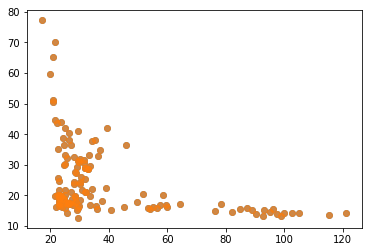

In [21]:

# plot result
tmp = res_df.loc[0, ['kappas','rhos']]
kappas = tmp['kappas']
rhos = tmp['rhos']
plt.plot(kappas, rhos, 'o', alpha = 0.7)

tmp = res_df.loc[res_df.score == res_df.score.min(), ['kappas','rhos']]
kappas = tmp['kappas'].values[0]
rhos = tmp['rhos'].values[0]
plt.plot(kappas, rhos, 'o', alpha = 0.7)


In [22]:
# save resdf if you're happy with the results, otherwise, go back up and more perturbations
res_df.to_pickle('./perturbation_results_%s.pickle.gz'%strftime("%Y-%m-%d_%H:%M:%S", gmtime()))
# an example of how to load save results
#test_load = pd.read_pickle('./perturbation_results_2017-11-22_15:52:35.pickle.gz')

In [ ]:
# take our new best mmix and reenter the normal meica processing pipline
mmix_orig = res_df.loc[res_df.score == res_df.score.min(), ['mmix']].values[0][0]
seldict,comptable,betas,mmix = fitmodels_direct(catd,mmix_orig,mask,t2s,t2sG,tes,combmode,head, fout=options.fout,reindex=True)

np.savetxt('meica_mix.1D',mmix)
if 'GROUP0' in sys.argv:
    group0_flag = True
else: group0_flag = False
acc,rej,midk,empty = selcomps(seldict,mmix,head, knobargs=options,group0_only=group0_flag,strict_mode=options.strict)

if len(acc)==0:
    print("\n** WARNING! No BOLD components detected!!! Please check data and results!\n")

writeresults(OCcatd, comptable, mmix, nt, acc, rej, midk, empty, head)
gscontrol_mmix(mmix, acc, rej, midk, empty, head)
if options.dne: writeresults_echoes(acc, rej, midk, head)

Out shape is  (42, 56, 38, 256)


In [366]:
!ls

T1gs.nii	      csstepdata.txt	 mepca_mix.1D	    t2sv.nii
__clin.nii.gz	      dn_ts_OC.nii	 midk_rejected.txt  t2svG.nii
__clout.nii.gz	      dn_ts_OC_T1c.nii	 midk_ts_OC.nii     ts_OC.nii
accepted.txt	      feats_OC2.nii	 pcastate.pklgz     tsoc_nogs.nii
betas_OC.nii	      glsig.1D		 rejected.txt	    tsoc_orig.nii
betas_hik_OC.nii      hik_ts_OC.nii	 s0v.nii	    veins_l0.nii
betas_hik_OC_T1c.nii  hik_ts_OC_T1c.nii  s0vG.nii	    veins_l1.nii
comp_table.txt	      lowk_ts_OC.nii	 s0vs.nii
comp_table_pca.txt    meica_mix.1D	 sphis_hik.nii
csdata.txt	      meica_mix_T1c.1D	 t2ss.nii


# Graveyard

code I'm not using any more that might be usefull later

In [253]:
from scipy.optimize import basinhopping
def print_fun(x, f, accepted):
    print("at minimum %.4f accepted %d" % (f, int(accepted)))
def get_score(Kappas, Rhos):
    return(-1*(Kappas.sum() + np.abs(Kappas - Rhos).sum() + Rhos.sum()))

In [254]:
res = basinhopping(run_perturb,np.random.randn(130,130)[np.triu_indices(130)], disp = True, callback = print_fun)

KeyboardInterrupt: 

In [345]:
%lprun -f get_kappas_rhos run_perturb(np.random.randn(130,130)[np.triu_indices(130)],0.001, res_df.loc[res_df.score == res_df.score.min(), ['mmix']].values[0][0])